# Number 3: Columns Joins 

You have two datasets:

* An Excel document of obesity rates, called `obesity.xlsx`
* A shapefile of US states from the [Census Burea](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html), unzipped into `cb_2016_us_state_500k/`

You're going to make a choropleth of obesity rates in US states.

**MAKE SURE YOU HAVE COMPLETED PART TWO BEFORE YOU DO THIS ONE.**

## Part Zero: Import what you need

I'm not giving you any more hints!

In [48]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
import fiona

## Part One: Opening your datasets

**Open up both files!** Think about what kind of file each one is before you try to open it.

In [49]:
# obesity = gpd.read_file("/Users/amandajames/Desktop/13-homework/obesity.xlsx")

# obesity = obesity.to_crs(gallery.crs)
# obesity.crs = {'init': 'epsg:4326'}
# neighborhoods.head()
obesity=pd.read_excel("obesity.xlsx")
obesity.head()

,statename,pct
0,Alabama,31.1
1,Alaska,27.7
2,Arizona,24.4
3,Arkansas,33.2
4,California,22.2


In [50]:
states = gpd.read_file("/Users/amandajames/Desktop/13-homework/cb_2016_us_state_500k/cb_2016_us_state_500k.shp")
states.crs = {'init': 'epsg:4326'}
states.head(10)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
1,0400000US02,1477946266785,245390495931,02,00,Alaska,02,01785533,AK,"(POLYGON ((-134.737262 58.261354, -134.73441 5..."
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3..."
3,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ..."
4,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ..."
5,0400000US08,268429343790,1175112870,08,00,Colorado,08,01779779,CO,"POLYGON ((-109.060253 38.599328, -109.059541 3..."
6,0400000US09,12542638347,1815476291,09,00,Connecticut,09,01779780,CT,"(POLYGON ((-72.761427 41.242333, -72.759733 41..."
7,0400000US10,5047194742,1398720828,10,00,Delaware,10,01779781,DE,"(POLYGON ((-75.565546 39.51485, -75.5617429999..."
8,0400000US11,158364992,18633403,11,00,District of Columbia,11,01702382,DC,"POLYGON ((-77.119759 38.934343, -77.1125318000..."
9,0400000US13,149169848456,4741100880,13,00,Georgia,13,01705317,GA,"(POLYGON ((-81.27939099999999 31.30792, -81.27..."


## Part Two: Map the states, just for fun

To double-check that the states look okay, make a quick map of them.

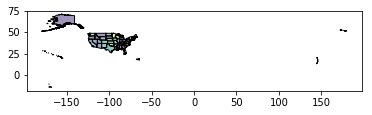

In [51]:
ax=states.plot()

Uh, well, let's just stick to the continental Uninted States for now. An easy way to do this is by creating a **bounding box** and filtering out the ones that aren't inside.

I like to use [this dumb site](https://itouchmap.com/latlong.html) to find the latitude and longitude of specific points, but if I'm just trying to figure out a box I use [geojson.io](http://geojson.io/) and just... draw a box and see what it tells me.

For example, down below I am only selecting **the northeast**. I got the boundaries by drawing a box on geojson.io. We also use our good friend **`.within`** from last time to say hey states, which ones of you are inside of the boundary box?

In [52]:
from shapely.geometry import Polygon

bounds = [
            [
              -80.68359375,
              37.75334401310656
            ],
            [
              -65.91796875,
              37.75334401310656
            ],
            [
              -65.91796875,
              48.37084770238366
            ],
            [
              -80.68359375,
              48.37084770238366
            ],
            [
              -80.68359375,
              37.75334401310656
            ]
]

# Turn the coordinates into a shapely polygon
northeast_box = Polygon(bounds)

# Make sure our state CRS is in lat/lng by using to_crs
# You could also just have done
# states = states.to_crs({'init': 'epsg:4326'})
# and converted it permanently once instead of doing it multiple times later on
states.to_crs({'init': 'epsg:4326'}).within(northeast_box).head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6     True
7     True
8     True
9    False
dtype: bool

And of course we can take those `True` and `False` values and feed them back into `states` to only get the states we're interested in. I plot them below, but you could always save them to a variable instead!

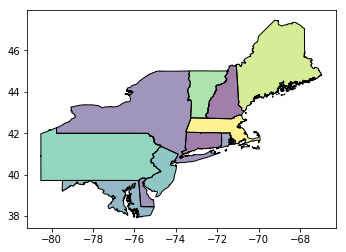

In [53]:
states[states.to_crs({'init': 'epsg:4326'}).within(northeast_box)].plot()

## Part Three: Filter your states

So *I* selected only states in the northeast. Now it's your job to use that new skill to **filter out any states that aren't in the continental USA.**

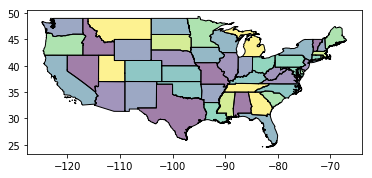

In [62]:
from shapely.geometry import Polygon

top = 51.3457868 # north lat
left = -124.7844079 # west long
right = -65.9513812 # east long
bottom =  20.7433195

bounds = [
            [
              left,
              bottom
            ],
            [
              right,
              bottom
            ],
            [
              right,
              top
            ],
            [
              left,
              top
            ],
            [
              left,
              bottom
            ]
]

# Turn the coordinates into a shapely polygon
statesbox = Polygon(bounds)

# Make sure our state CRS is in lat/lng by using to_crs
# You could also just have done
# states = states.to_crs({'init': 'epsg:4326'})
# and converted it permanently once instead of doing it multiple times later on
states[states.to_crs({'init': 'epsg:4326'}).within(statesbox)].plot()

## Part Four: Joining your data

You have some obesity data, it looks like this:

In [63]:
obesity.head(3)

,statename,pct
0,Alabama,31.1
1,Alaska,27.7
2,Arizona,24.4


You have some states, they look like this:

In [64]:
states.head(3)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
1,0400000US02,1477946266785,245390495931,02,00,Alaska,02,01785533,AK,"(POLYGON ((-134.737262 58.261354, -134.73441 5..."
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3..."


You need to **merge them together** using [merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html), which is just a normal pandas thing we've done before.

**THIS IS NOT A SPATIAL JOIN.** We're just saying hey, you guys both have columns that match, right? You might want to get together.

All `.merge` needs is two dataframes and a `left_on`/`right_on` to specify which columns to match up. Unlike a spatial join, for most column joins it doesn't matter which one is "left" and which one is "right."

In [65]:
newdf= obesity.merge(states, left_on='statename', right_on='NAME')
newdf

,statename,pct,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,Alabama,31.1,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
1,Alaska,27.7,0400000US02,1477946266785,245390495931,02,00,Alaska,02,01785533,AK,"(POLYGON ((-134.737262 58.261354, -134.73441 5..."
2,Arizona,24.4,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3..."
3,Arkansas,33.2,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ..."
4,California,22.2,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ..."
5,Colorado,19.1,0400000US08,268429343790,1175112870,08,00,Colorado,08,01779779,CO,"POLYGON ((-109.060253 38.599328, -109.059541 3..."
6,Connecticut,24.0,0400000US09,12542638347,1815476291,09,00,Connecticut,09,01779780,CT,"(POLYGON ((-72.761427 41.242333, -72.759733 41..."
7,Delaware,29.4,0400000US10,5047194742,1398720828,10,00,Delaware,10,01779781,DE,"(POLYGON ((-75.565546 39.51485, -75.5617429999..."
8,District of Columbia,9.9,0400000US11,158364992,18633403,11,00,District of Columbia,11,01702382,DC,"POLYGON ((-77.119759 38.934343, -77.1125318000..."
9,Florida,25.2,0400000US12,138924199212,31386038155,12,00,Florida,12,00294478,FL,"(POLYGON ((-80.176276 25.525054, -80.173949999..."


## Part Five: Mapping your data

Map it. Familiar projection, nice large size, etc. Use a [nice color map](https://matplotlib.org/examples/color/colormaps_reference.html) that makes sense.

The one below is Mercator - you can see the grumpy top of the USA - see if you can make it something better! Maybe find the EPSG code for an Albers Equal Area that's good for the continental United States?

In [85]:
# newdf.to_crs =({'init': 'epsg:5070'})

from shapely.geometry import Polygon

top = 51.3457868 # north lat
left = -124.7844079 # west long
right = -65.9513812 # east long
bottom =  20.7433195

bounds = [
            [
              left,
              bottom
            ],
            [
              right,
              bottom
            ],
            [
              right,
              top
            ],
            [
              left,
              top
            ],
            [
              left,
              bottom
            ]
]

# Turn the coordinates into a shapely polygon
statesbox = Polygon(bounds)

# Make sure our state CRS is in lat/lng by using to_crs
# You could also just have done
# states = states.to_crs({'init': 'epsg:4326'})
# and converted it permanently once instead of doing it multiple times later on
# ax = gpd.GeoDataFrame(newdf)
# newdf.crs={'init':'epsg:4326'}
ax=ax[ax.to_crs({'init': 'epsg:4326'}).within(statesbox)]

# ax.plot(figsize=(40,20), cmap='plasma')


To get a different look, try passing `legend=True` and `scheme='Quantiles'`.

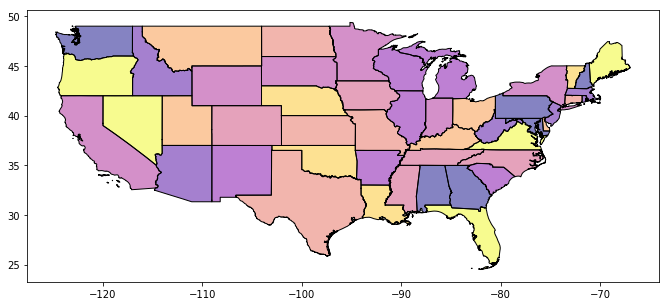

In [93]:
ax.plot(legend='True',scheme='Quantiles', figsize=(25,5), cmap='plasma')

And oooone more time with `legend=True` and `scheme='equal_interval'`

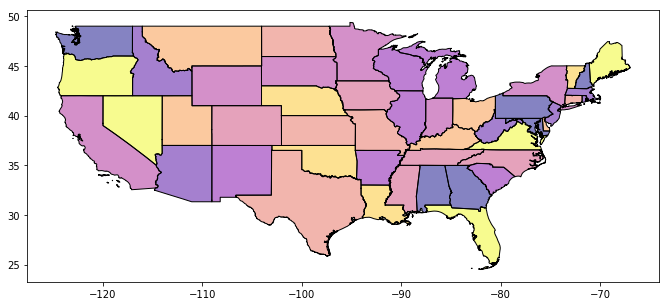

In [94]:
ax.plot(legend='True',scheme='equal_interval', figsize=(25,5), cmap='plasma')

## Think about which one does the best job telling the story.

We'll talk about this next class.